<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/CE_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
data_dir = '/content/drive/MyDrive/Research/Crowd Emotion/Spectrograms/Mel/'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = data_dir,
    validation_split          = 0.2,
    subset                    = "training",
    seed                      = 42,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 3857 files belonging to 3 classes.
Using 3086 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = data_dir,
    validation_split          = 0.2,
    subset                    = "validation",
    seed                      = 42,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 3857 files belonging to 3 classes.
Using 771 files for validation.


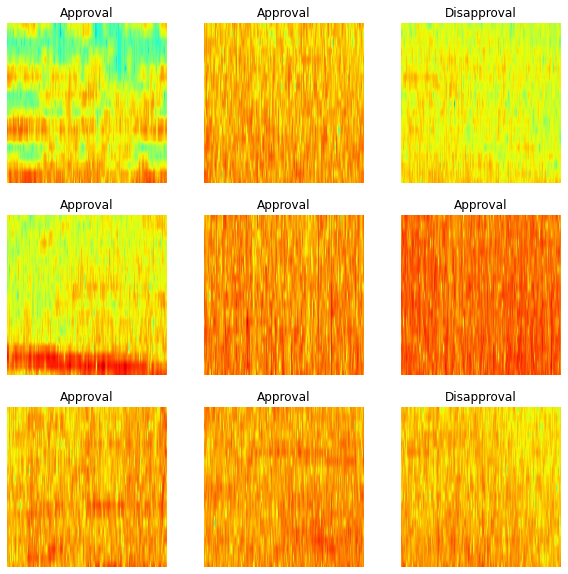

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
base_model.trainable = False

In [13]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843  

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

25/25 [==============================] - 229s 5s/step - loss: 1.0490 - accuracy: 0.5214


In [20]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
97/97 [==============================] - 792s 8s/step - loss: 0.8677 - accuracy: 0.6163 - val_loss: 0.7020 - val_accuracy: 0.7004
Epoch 2/10
97/97 [==============================] - 10s 93ms/step - loss: 0.7232 - accuracy: 0.6841 - val_loss: 0.7100 - val_accuracy: 0.6796
Epoch 3/10
97/97 [==============================] - 10s 93ms/step - loss: 0.6755 - accuracy: 0.7080 - val_loss: 0.6009 - val_accuracy: 0.7575
Epoch 4/10
97/97 [==============================] - 10s 94ms/step - loss: 0.6344 - accuracy: 0.7323 - val_loss: 0.6190 - val_accuracy: 0.7302
Epoch 5/10
97/97 [==============================] - 10s 93ms/step - loss: 0.6100 - accuracy: 0.7421 - val_loss: 0.5851 - val_accuracy: 0.7575
Epoch 6/10
97/97 [==============================] - 10s 93ms/step - loss: 0.5888 - accuracy: 0.7566 - val_loss: 0.5855 - val_accuracy: 0.7639
Epoch 7/10
97/97 [==============================] - 10s 93ms/step - loss: 0.5792 - accuracy: 0.7690 - val_loss: 0.5695 - val_accuracy: 0.7601
Epoch 8

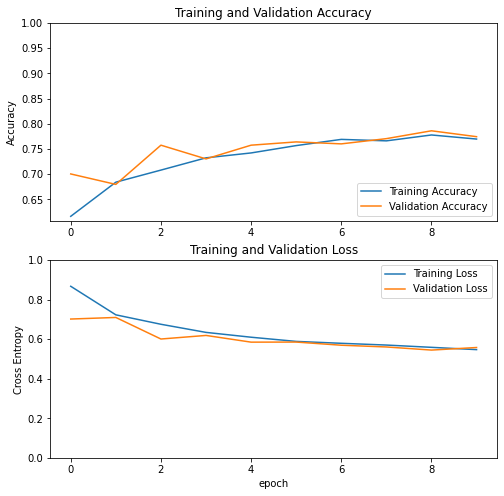

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
"""
                TRAINING           TESTING
        BARK      94.65             93.51
        ERB       82.08             79.64             
        LOG       95.01             93.90
        MEL       76.96             77.43            
"""

'\n                TRAINING           TESTING\n        BARK      94.65             93.51\n        ERB       82.08             79.64             \n        LOG       95.01             93.90\n        MEL                   \n'